# Program optimization

So, you have a program, which implements an algorithm. It works. Results make sense. You have a suite of tests with reasonable coverage. 

The only *slight* problem is your program is slow. Sloth slow. You want to improve performance, i.e. optimize the program.


**Fact:** Whenever you try to guess what is slow in your program, **you guess wrong.**

## The optimization loop

1. Profile the program. Identify the hotspots.

2. Optimize the bottleneck. *Only* touch the bottleneck, nothing else.

3. Verify that the program still works (**tests!**)

4. Measure the execution time. 

5. Goto 1.

## Profiling

e.g. GNU `gprof`, `ccachegrind`, `google-perftools`, `yep`, ...

In Python, use the `cProfile` module from the standard library for the function-level profiling. 
In Jupyter, there's a convenince magic, `%prun`.

As an example, we consider the adaptive integration scheme from a couple of weeks back.

In [1]:
import numpy as np

In [2]:
# A rectangle is (start, width)
# A list element is (-weight, (start, width))

def make_rect(a, b, f):
    """Make a rectangle for the interval [a, b]"""
    rect = (a, b-a)
    xm = a + rect[1] / 2.
    return (-f(xm) * rect[1], rect)
    

def get_max_elem(lst, key=None):
    """Find and remove the maximum element from the list.
    
    Find the max element (according to the parameter `key`,
    which is a callable), remove it from the list, and
    return both the element and the rest.
    """
    if key is None:
        # use the identity function
        key = lambda x: x
    
    # find the max element
    elem = max(lst, key=key)
    
    # find its position in the list
    idx = lst.index(elem)
    
    return elem, lst[:idx] + lst[idx+1:]

    
def adapt_rect_list(f, a, b, npts):
    """Integrate f(x) from a to b using npts steps.
    
    Uses an adaptive algorithm.
    """
    lst = []

    # start from a single rectangle
    item = make_rect(a, b, f)
    lst.append(item)
    
    # loop
    for _ in range(npts):
        # get the largest one
        rect, lst = get_max_elem(lst, lambda x: -x[0])
        w, (start, width) = rect
                
        # and split it into two halves
        c = start + width / 2.
        
        rect1 = make_rect(start, c, f)
        rect2 = make_rect(c, start + width, f)
        
        lst.append(rect1)
        lst.append(rect2)
        
    # collect the answer
    return -sum(w for w, r in lst), lst

In [3]:
def func(x):
    return np.tan(x) / (1.0 + np.exp(x))

a, b = 0, 10

In [4]:
# this opens a profile in the Jupyter's pager

%prun adapt_rect_list(func, a, b, npts=1000)

In [5]:
# alternatively, save the `pstats.Stats` object and manipulate it 

stats = %prun -r -q adapt_rect_list(func, a, b, npts=5000)

stats.print_stats(20)

          12552510 function calls in 4.360 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     5000    2.819    0.001    4.087    0.001 {built-in method builtins.max}
 12502500    1.268    0.000    1.268    0.000 <ipython-input-2-d80a194c1915>:45(<lambda>)
     5000    0.152    0.000    4.244    0.001 <ipython-input-2-d80a194c1915>:11(get_max_elem)
        1    0.049    0.049    4.359    4.359 <ipython-input-2-d80a194c1915>:31(adapt_rect_list)
    10001    0.047    0.000    0.047    0.000 <ipython-input-3-0da83198508c>:1(func)
    10001    0.011    0.000    0.058    0.000 <ipython-input-2-d80a194c1915>:4(make_rect)
    10001    0.006    0.000    0.006    0.000 {method 'append' of 'list' objects}
     5000    0.005    0.000    0.005    0.000 {method 'index' of 'list' objects}
        1    0.001    0.001    0.002    0.002 {built-in method builtins.sum}
        1    0.001    0.001    4.360    4.360 <string>:1(<module>)
     5

## Line level profiling

In python land, use the `line_profiler` module. It's not in the standard library, so we need to install it. Open the `Anaconda prompt`, then type `conda install line_profiler`.

If using `pip`, type `pip install line_profiler --user`.

There also is an associated Jupyter magic. For using it outside of Jupyter, consult the [documentation: https://github.com/rkern/line_profiler.](https://github.com/rkern/line_profiler)

In [6]:
%load_ext line_profiler

In [7]:
# note that we need to give it the name of the function to profile via a `-f` switch

%lprun -f adapt_rect_list adapt_rect_list(func, a, b, 1000)

In [8]:
# again, save the results object (via a `-r` switch)

lstats = %lprun -r -f adapt_rect_list adapt_rect_list(func, a, b, 1000)

lstats.print_stats()

Timer unit: 1e-07 s

Total time: 0.289059 s
File: <ipython-input-2-d80a194c1915>
Function: adapt_rect_list at line 31

Line #      Hits         Time  Per Hit   % Time  Line Contents
    31                                           def adapt_rect_list(f, a, b, npts):
    32                                               """Integrate f(x) from a to b using npts steps.
    33                                               
    34                                               Uses an adaptive algorithm.
    35                                               """
    36         1         18.0     18.0      0.0      lst = []
    37                                           
    38                                               # start from a single rectangle
    39         1        255.0    255.0      0.0      item = make_rect(a, b, f)
    40         1         11.0     11.0      0.0      lst.append(item)
    41                                               
    42                                  

In [9]:
# since we spend 90% of time in the `get_max_elem` function, profile it

lstats = %lprun -r -f get_max_elem adapt_rect_list(func, a, b, 1000)

lstats.print_stats()

Timer unit: 1e-07 s

Total time: 0.23534 s
File: <ipython-input-2-d80a194c1915>
Function: get_max_elem at line 11

Line #      Hits         Time  Per Hit   % Time  Line Contents
    11                                           def get_max_elem(lst, key=None):
    12                                               """Find and remove the maximum element from the list.
    13                                               
    14                                               Find the max element (according to the parameter `key`,
    15                                               which is a callable), remove it from the list, and
    16                                               return both the element and the rest.
    17                                               """
    18      1000       9071.0      9.1      0.4      if key is None:
    19                                                   # use the identity function
    20                                                   key = l

## The best optimization is often an algorithmic one

The bottleneck is searching the largest weight interval. There is a data structure for it: priority queue. 

> In a priority queue, an element with high **priority** is served before an element with low **priority**.

(Quote from Wikipedia)

It's even implemented in the standard library module `heapq`: https://docs.python.org/3.8/library/heapq.html

This way, you _push_ rectangles into the queue and _pop_ the largest weight one from it. 
(see `heapq.heappush` and `heapq.heappop` functions).

## Exercise

Implement the adaptive integration routine using the `heapq` module. 
- verify the result of your routine.
- measure and plot running time vs number of intervals, compare to the naive rountine above.
- line profile the result

In [10]:
from heapq import heapify, heappush, heappop

In [11]:
# A rectangle is (start, width)
# A list element is (-weight, (start, width))
   
def adapt_rect_queue(f, a, b, npts):
    """Integrate f(x) from a to b using npts steps.
    
    Uses an adaptive algorithm.
    """
    # create empty heap
    lst = []
    heapify(lst) 

    # start from a single rectangle
    item = make_rect(a, b, f)
    heappush(lst, item) #push in heap
    
    # loop
    for _ in range(npts):
        #get and remove the minimun element from the heap
        rect = heappop(lst)

        w, (start, width) = rect
                
        # and split it into two halves
        c = start + width / 2.
        
        rect1 = make_rect(start, c, f)
        rect2 = make_rect(c, start + width, f)

        heappush(lst, rect1)
        heappush(lst, rect2)
        
    # collect the answer
    return -sum(w for w, r in lst), lst

## Протестируем правильность программы на функции из ноутбука integrals.ipynb: $f(x) = e^{-x}$, a = 0, b = 20

**Используем изначальную реализацию:**

In [12]:
def f(x):
    return np.exp(-x)

a, b = 0, 20

for n in (5, 25, 125, 250, 500, 1000, 5000):
    res, lst = adapt_rect_list(f, a, b, n)
    print ('list: n, res = ', n, res)

list: n, res =  5 0.9552698388347781
list: n, res =  25 0.9786718962428081
list: n, res =  125 0.9956502001607699
list: n, res =  250 0.9959491604791242
list: n, res =  500 0.9960027891786778
list: n, res =  1000 0.9997391610745809
list: n, res =  5000 0.999940521244624


**Используем кучу:**

In [13]:
for n in (5, 25, 125, 250, 500, 1000, 5000):
    res, lst = adapt_rect_queue(f, a, b, n)
    print ('queue: n, res = ', n, res)

queue: n, res =  5 0.955269838834778
queue: n, res =  25 0.978671896242808
queue: n, res =  125 0.9956502001607697
queue: n, res =  250 0.9959491604791236
queue: n, res =  500 0.9960027891786782
queue: n, res =  1000 0.9997391610745805
queue: n, res =  5000 0.9999405212446223


**Совпадает!**

## Измерим время работы в зависимости от числа интервалов для изначальной реализации.

In [14]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [16]:
import time 

def elapsed_time(alg, ns):
    """Функция для измерения времени работы алгоритма alg
    в зависимости от числа интервалов ns.

    Возвращает список усредненных значений пройденного времени
    для каждого числа интервалов. """
 
    times = []
    for n in ns:
        all_time = 0
        for _ in range(10): #пройдемся 10 раз для усреднения времени работы
            start_time = time.time()
            res, lst = alg(f, a, b, n)
            end_time = time.time()
            all_time += end_time - start_time
        times.append(all_time / 10) 
    return times

In [17]:
ns = [5, 10, 20, 25, 50, 100, 200, 250, 500, 750, 1000, 1500, 2000, 2500, 3500, 5000]

times_for_list = elapsed_time(adapt_rect_list, ns)

Text(0.5, 1.0, 'Время работы адапт. алг в зав. от n для изн. реализации')

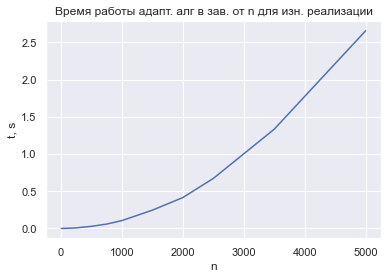

In [18]:
plt.plot(ns, times_for_list)
plt.xlabel('n')
plt.ylabel('t, s')
plt.title('Время работы адапт. алг в зав. от n для изн. реализации')

**Зависимость выглядит как квадратичная. Проверим это с помощью curve_fit из scipy.optimize.**

In [19]:
from scipy.optimize import curve_fit

In [20]:
def approximated(x, y):
    c, _ = curve_fit(square_func, x, y)    
    return square_func(x, c), c
    
def square_func(x, c):
    return c * x ** 2 

In [21]:
times_for_list = np.array(times_for_list)
ns = np.array(ns)

In [22]:
times_appr, c = approximated(ns, times_for_list)

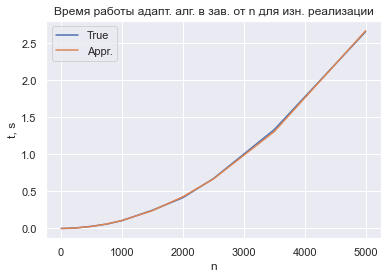

In [23]:
plt.plot(ns, times_for_list)
plt.plot(ns, times_appr)

plt.xlabel('n')
plt.ylabel('t, s')
plt.title('Время работы адапт. алг. в зав. от n для изн. реализации')
plt.legend(['True', 'Appr.'])

**Действительно, зависимость квадратичная!**

In [24]:
times_for_queue = elapsed_time(adapt_rect_queue, ns)

Text(0.5, 1.0, 'Время работы адапт. алг. в зав. от n для реализации с кучей')

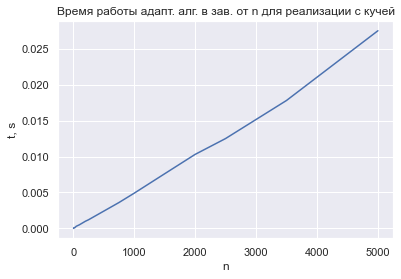

In [25]:
plt.plot(ns, times_for_queue)
plt.xlabel('n')
plt.ylabel('t, s')
plt.title('Время работы адапт. алг. в зав. от n для реализации с кучей')

**Зависимость линейная.**

# Проведем line level profiling

**Посмотрим, какая строчка теперь является самой дорогой по времени:**

In [26]:
lstats = %lprun -r -f adapt_rect_queue adapt_rect_queue(func, a, b, 1000)

lstats.print_stats()

Timer unit: 1e-07 s

Total time: 0.0178688 s
File: <ipython-input-11-087f8dd2030f>
Function: adapt_rect_queue at line 4

Line #      Hits         Time  Per Hit   % Time  Line Contents
     4                                           def adapt_rect_queue(f, a, b, npts):
     5                                               """Integrate f(x) from a to b using npts steps.
     6                                               
     7                                               Uses an adaptive algorithm.
     8                                               """
     9                                               # create empty heap
    10         1         16.0     16.0      0.0      lst = []
    11         1         14.0     14.0      0.0      heapify(lst) 
    12                                           
    13                                               # start from a single rectangle
    14         1        247.0    247.0      0.1      item = make_rect(a, b, f)
    15         1     

**Видно, что теперь это не поиск максимума, а создание прямоугольника. Можем также посмотреть выполнение какой именно строчки make_rect() занимает основное время**

In [27]:
lstats = %lprun -r -f make_rect adapt_rect_queue(func, a, b, 1000)

lstats.print_stats()

Timer unit: 1e-07 s

Total time: 0.0123409 s
File: <ipython-input-2-d80a194c1915>
Function: make_rect at line 4

Line #      Hits         Time  Per Hit   % Time  Line Contents
     4                                           def make_rect(a, b, f):
     5                                               """Make a rectangle for the interval [a, b]"""
     6      2001      13075.0      6.5     10.6      rect = (a, b-a)
     7      2001      12044.0      6.0      9.8      xm = a + rect[1] / 2.
     8      2001      98290.0     49.1     79.6      return (-f(xm) * rect[1], rect)



**Собственно, это вычисления, которые мы уже вряд ли сможем сильно ускорить, так как они происходят на уровне numpy.**

## Further reading

1. [cProfile] Doug Hellmann, *profile and pstats — Performance Analysis*, https://pymotw.com/3/profile/

2. [line_profiler] Robert Kern, *Line profiler documentation*, https://github.com/rkern/line_profiler

3. [yep] Fabian Pedregosa, *Profiling in Python*, http://www.slideshare.net/FabianPedregosa/profiling-in-python-54685566

Note however that `yep` is reported to not work under Windows. However I personally have had a very good experience using it (on Linux systems) when writing extension modules in C/C++.